In [2]:
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy.fftpack import fft
from scipy.ndimage.filters import gaussian_filter

from sklearn.metrics import f1_score

plt.style.use('seaborn')

### Import Data

In [3]:
from utils.data import *

In [4]:
x_train, y_train = load_training_data()

In [5]:
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

Shape of x_train: (45360, 512, 3)
Shape of y_train: (45360,)


### Extract Features with PyEEG

In [6]:
import pyeeg

In [ ]:
# Too slow
fisher_info = np.apply_along_axis(pyeeg.fisher_info, axis=1, 
                                  arr=x_train, Tau=4, DE=10)

ap_entropy = np.apply_along_axis(pyeeg.ap_entropy, axis=1, 
                                 arr=x_train[:100], M=2, R=0.5)

In [ ]:
def extract_data(x):
    # Generate data set with extracted features
    # Takes long, save to numpy file afterwards
    
    pfd = np.apply_along_axis(pyeeg.pfd, axis=1, arr=x)

    hfd = np.apply_along_axis(pyeeg.hfd, axis=1, arr=x, Kmax=5)

    hjorth = np.apply_along_axis(pyeeg.hjorth, axis=1, arr=x)
    hjorth = hjorth.reshape(x.shape[0], 2 * x.shape[2])

    hurst = np.apply_along_axis(pyeeg.hurst, axis=1, arr=x)
    hurst = np.nan_to_num(hurst)

    dfa = np.apply_along_axis(pyeeg.dfa, axis=1, arr=x)

    spectral_entropy = np.apply_along_axis(pyeeg.spectral_entropy, axis=1, 
                                 arr=x, Band=[0.5,4,7,12,30,64], Fs=128)

    std = np.apply_along_axis(np.std, axis=1, arr=x)
    
    power_ratio = np.apply_along_axis(pyeeg.bin_power, axis=1, arr=x_train, Fs=128, 
                                      Band=[0.5,4,7,12,30,64])[:, 1, :, :]
    power_ratio = power_ratio.reshape(power_ratio.shape[0], power_ratio.shape[1] * power_ratio.shape[2])
    
    x_feat = np.concatenate((dfa, hfd, hjorth, pfd, spectral_entropy, hurst, std, power_ratio), axis=1)

x_train_feat = extract_training_data(x_train)

In [ ]:
np.save('data/x_train_feat', x_train_feat)
print(x_train_feat.shape)

In [7]:
x_train_feat = np.load('data/x_train_feat.npy')
print(x_train_feat.shape)

(45360, 39)


### Build Neural Network

In [8]:
# Generate weights for training (imbalanced classes)
class_weight = {}

count_0, count_1, count_2 = np.bincount(y_train)
total = count_0 + count_1 + count_2

for i in range(3):
    class_weight[i] = (1 / [count_0, count_1, count_2][i]) * total

In [9]:
# Split data for validation
x_train_feat_s, x_val_feat, y_train_s, y_val = train_test_split(x_train_feat, y_train, test_size=0.2, random_state=42)

In [28]:
model = keras.Sequential([
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='Adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

In [29]:
history = model.fit(x_train_feat_s, y_train_s, class_weight=class_weight, 
                    epochs=50, validation_data=(x_val_feat, y_val))

Train on 36288 samples, validate on 9072 samples
Epoch 1/50
36288/36288 [==============================] - 5s 136us/sample - loss: 6.8125 - acc: 0.5948 - val_loss: 0.5835 - val_acc: 0.8157
Epoch 2/50
36288/36288 [==============================] - 5s 127us/sample - loss: 2.6968 - acc: 0.6167 - val_loss: 0.6480 - val_acc: 0.7409
Epoch 3/50
36288/36288 [==============================] - 5s 128us/sample - loss: 2.5980 - acc: 0.6332 - val_loss: 0.8989 - val_acc: 0.4647
Epoch 4/50
36288/36288 [==============================] - 5s 128us/sample - loss: 2.5315 - acc: 0.6366 - val_loss: 0.8488 - val_acc: 0.6261
Epoch 5/50
36288/36288 [==============================] - 5s 131us/sample - loss: 2.4429 - acc: 0.6603 - val_loss: 0.4643 - val_acc: 0.8534
Epoch 6/50
36288/36288 [==============================] - 5s 129us/sample - loss: 2.3267 - acc: 0.6836 - val_loss: 0.5852 - val_acc: 0.7664
Epoch 7/50
36288/36288 [==============================] - 5s 132us/sample - loss: 2.0843 - acc: 0.7360 - val_lo

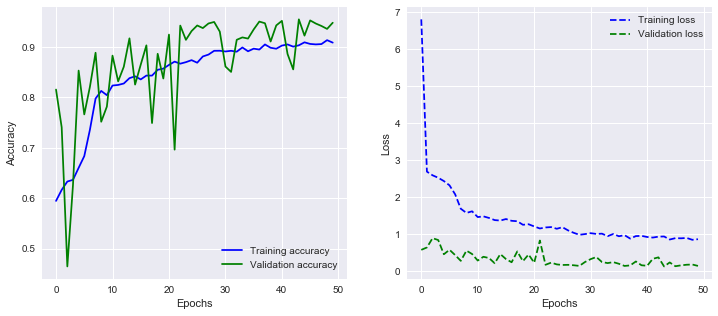

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(history.history["acc"], "b-", label="Training accuracy")
ax[0].plot(history.history["val_acc"], "g-", label="Validation accuracy")

ax[1].plot(history.history["loss"], "b--", label="Training loss")
ax[1].plot(history.history["val_loss"], "g--", label="Validation loss")

ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Loss")

ax[0].legend()
ax[1].legend()

In [31]:
train_f1 = f1_score(y_train, np.argmax(model.predict(x_train_feat), axis=1), average='macro')
print(f'F1 score on training data: {train_f1:.4f}')

F1 score on training data: 0.8981


In [32]:
val_f1 = f1_score(y_val, np.argmax(model.predict(x_val_feat), axis=1), average='macro')
print(f'F1 score on validation data: {val_f1:.4f}')

F1 score on validation data: 0.9053


### Evaluate on Test Data

In [33]:
x_test = load_testing_data()

In [ ]:
# Test set with extracted features
x_test_feat = extract_data(x_test)
np.save('data/x_test_feat', x_test_feat)
print(x_test_feat.shape)

In [34]:
x_test_feat = np.load('data/x_test_feat.npy')

In [35]:
# Get prediction & generate submission file
y_test_pred = model.predict(x_test_feat)
generate_submission(y_test_pred, 'DeepNN_Pred')